In [1]:
import glob
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(42)

# 1 Data preprocessing

Dataset: Dogs&Cats include 12.5K color cat images and 12.5K color dog images.

## (1) generate training, validation, and test sets

In [2]:
import copy
# Read all files from the fold 
_dataset_path = 'train/'
files = glob.glob(_dataset_path+"*")  #glob.glob is to extract the file into list

# save all cat images in cat_files

cat_files = []
dog_files = []

for f in files:
    fn = f.split('/')[-1].split('.')[0]
    if fn == 'cat':
        cat_files.append(f)
    elif fn == 'dog':
        dog_files.append(f)
    else:
        print("error:{}".format(f))

#cat_files = copy.deepcopy([fn for fn in files if 'cat' in fn])
#dog_files = copy.deepcopy([fn for fn in files if 'dog' in fn])


In [3]:
cat_files = np.array(cat_files)
dog_files = np.array(dog_files)

np.random.shuffle(cat_files)
np.random.shuffle(dog_files)

cat_train = cat_files[:1500]
cat_val = cat_files[1500:2000]
cat_test = cat_files[2000:2500]

dog_train = dog_files[:1500]
dog_val = dog_files[1500:2000]
dog_test = dog_files[2000:2500]
print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


## (2) Save 3 data sets in individual fold

### (a) generate folds

In [4]:
# Create directories
def create_folder(_fold_path):
    try:
        os.makedirs(_fold_path)
    except OSError:
        print("***folder already exist***")

In [5]:
_asset_path = 'asset/dog_cat/'

#named the directory of data set
train_dir = _asset_path+'training_data/'
val_dir = _asset_path+'validation_data/'
test_dir = _asset_path+'test_data/'

create_folder(train_dir)
create_folder(val_dir)
create_folder(test_dir)

***folder already exist***
***folder already exist***
***folder already exist***


In [6]:
# #named the directory of data set
# train_dir = 'training_data'
# val_dir = 'validation_data'
# test_dir = 'test_data'

# os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
# os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
# os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

In [7]:
train_files = np.append(cat_train, dog_train)
validate_files = np.append(cat_val, dog_val)
test_files = np.append(cat_test, dog_test)

In [8]:
from shutil import copy2
def copy_to_dir(src_path, dst_path):
    for f in src_path:
        f_name = f.split("/")[-1]
        copy2(f,dst_path+f_name)
    print("sucess")     
    return


In [9]:
copy_to_dir(train_files, train_dir)
copy_to_dir(validate_files, val_dir)
copy_to_dir(test_files, test_dir)

sucess
sucess
sucess


### (b) save data sets in build folds

In [10]:
# the input shape
IMG_DIM = (150, 150)

# To extract the samples from directory of train
train_files = glob.glob(train_dir+"*") 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in train_files]

# To extract the samples from directory of val
validation_files = glob.glob(val_dir+'*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob(test_dir+'*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [11]:
train_files[1].split('/')[-1].split('.')[0].strip()

'dog'

### (c) transfer category labels to discrete values

In [12]:
from sklearn.preprocessing import LabelEncoder

# encode labels
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'cat', 'dog', 'cat'] [1 1 0 1 0]


# 2 Review CNN

![jupyter](https://cdn-images-1.medium.com/max/800/1*R-ItxBW2SWarITBKe7HZuA.gif)

##  (1) rescale image size from 0~255 to 0~1

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen  = ImageDataGenerator(rescale=1./255)

In [14]:
# To generate the sample from ImageDataGenerator
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

##  (2) Build sequential CNN model

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
# designing the model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# To comile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
# To show the construction of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [16]:
# To set up the parameter
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/20
100/100 [==============================] - 6s 64ms/step - loss: 0.6780 - acc: 0.5497 - val_loss: 0.6740 - val_acc: 0.5700
Epoch 2/20
100/100 [==============================] - 4s 44ms/step - loss: 0.6363 - acc: 0.6447 - val_loss: 0.6347 - val_acc: 0.6190
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 0.6026 - acc: 0.6823 - val_loss: 0.6033 - val_acc: 0.6530
Epoch 4/20
100/100 [==============================] - 4s 45ms/step - loss: 0.5844 - acc: 0.6933 - val_loss: 0.5710 - val_acc: 0.6970
Epoch 5/20
100/100 [==============================] - 4s 44ms/step - loss: 0.5539 - acc: 0.7097 - val_loss: 0.5562 - val_acc: 0.7010
Epoch 6/20
100/100 [==============================] - 4s 45ms/step - loss: 0.5333 - acc: 0.7300 - val_loss: 0.5678 - val_acc: 0.6950
Epoch 7/20
100/100 [==============================] - 4s 44ms/step - loss: 0.5089 - acc: 0.7510 - val_loss: 0.5879 - val_acc: 0.6950
Epoch 8/20
100/100 [==============================] - 4s 44ms/step - 

## (3) Visualize the results of training and validation

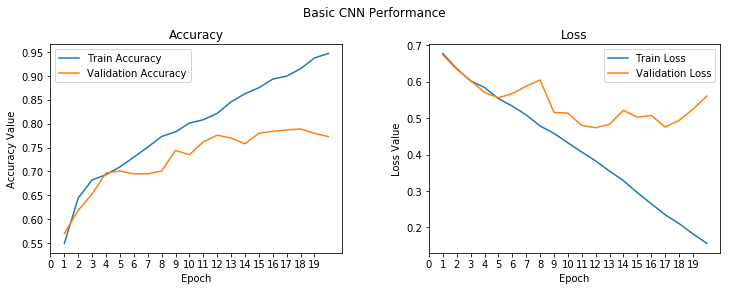

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 20, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 20, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
model.save('cats_dogs_cnn_img_aug.h5') ##????????????

## (4) testing

In [19]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(test_imgs, test_labels_enc)
print('test loss, test acc:', results)



# Evaluate on test data
1000/1000 [==============================] - 1s 613us/step
test loss, test acc: [4.930410331726074, 0.691]


# Exercise 1. Build functional CNN model on the same data set

In [20]:
## 1 import used layers ##

############################
## Insert your code here ###
############################



Using TensorFlow backend.


In [37]:
## 2 Read data and Rescale data
############################
## Insert your code here ###
############################
# To extract the samples from directory of train

# the input shape


Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [39]:

# To generate the sample from ImageDataGenerator

## numbers of samples = steps_per_epoch*batch_size, 


## numbers of samples = steps_per_epoch*batch_size, 


In [24]:
## 3 Build function CNN model
############################
## Insert your code here ###
############################
# define network
input_shape=(150,150,3)
img_input = Input(shape=input_shape)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(img_input)
x = MaxPooling2D((2, 2), padding='same')(x)
    
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
    
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
    
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x= Flatten()(x)
output = Dense(512,activation='relu')(x)
output = Dense(512,activation='relu')(x)
output = Dense(1,activation='sigmoid')(x)

model = Model(img_input, output)

In [ ]:
# To comile the model


# To set up the parameter


In [ ]:
## 4 Visualization
############################
## Insert your code here ###
############################

In [ ]:
## 5 test
############################
## Insert your code here ###
############################
# Evaluate the model on the test data using `evaluate`

# Exercise 2 Build sequential and functional CNN models for butterfly

# interpret the introduction of butterfly
The training, validation, and test sets have been save in the folds, './asset/data/train/','./asset/data/valid/','./asset/data/test/'. 



In [28]:
## 1 import used layers ##

############################
## Insert your code here ###
############################


In [29]:
## 2 Read data and Rescale data


############################
## Insert your code here ###
############################

In [ ]:
# To generate the sample from ImageDataGenerator

## numbers of samples = steps_per_epoch*batch_size, 


## numbers of samples = steps_per_epoch*batch_size, 

In [ ]:
## back up for read data from folds


# To set up the training and val directory

In [31]:
input_shape = (150, 150, 3)

In [32]:
## (2) build CNN model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [ ]:
## (2.1) fit the model

In [ ]:
## (3) Visualization 

In [ ]:
## (4) Test
# Evaluate the model on the test data using `evaluate`
